In [1]:
import math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import rasterio
from rasterio.transform import Affine
from rasterio.warp import Resampling, reproject
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit

### Load plume examples

In [2]:
import os


def get_plume_paths(directory="/home/azureuser/orbio/methane-cv/notebooks/data/aviris_plumes"):
    """
    Reads all file paths in the specified directory and returns a list of those paths.

    Args:
        directory (str): The directory to search for files. Defaults to 'cv_data/AVIRIS_plumes'.

    Returns
    -------
        list: A list of full file paths.
    """
    plume_paths = []

    # Walk through the directory and gather file paths
    for root, _, files in os.walk(directory):
        for file in files:
            # Join the root path with the file name
            file_path = os.path.join(root, file)
            plume_paths.append(file_path)

    return plume_paths


# Example usage
plume_paths = get_plume_paths()
print(plume_paths)

['/home/azureuser/orbio/methane-cv/notebooks/data/aviris_plumes/ang20161008t212326-B_l3a-ch4-mf-v1_concentrations.tif', '/home/azureuser/orbio/methane-cv/notebooks/data/aviris_plumes/ang20170831t225148-A_l3a-ch4-mf-v1_concentrations.tif', '/home/azureuser/orbio/methane-cv/notebooks/data/aviris_plumes/ang20161008t204039-F_l3a-ch4-mf-v1_concentrations.tif', '/home/azureuser/orbio/methane-cv/notebooks/data/aviris_plumes/ang20160910t185702-A_l3a-ch4-mf-v1_concentrations.tif', '/home/azureuser/orbio/methane-cv/notebooks/data/aviris_plumes/ang20170905t181928-B_l3a-ch4-mf-v1_concentrations.tif', '/home/azureuser/orbio/methane-cv/notebooks/data/aviris_plumes/ang20160915t180022-B_l3a-ch4-mf-v1_concentrations.tif', '/home/azureuser/orbio/methane-cv/notebooks/data/aviris_plumes/ang20161008t205502-H_l3a-ch4-mf-v1_concentrations.tif', '/home/azureuser/orbio/methane-cv/notebooks/data/aviris_plumes/ang20161008t202359-H_l3a-ch4-mf-v1_concentrations.tif', '/home/azureuser/orbio/methane-cv/notebooks/dat

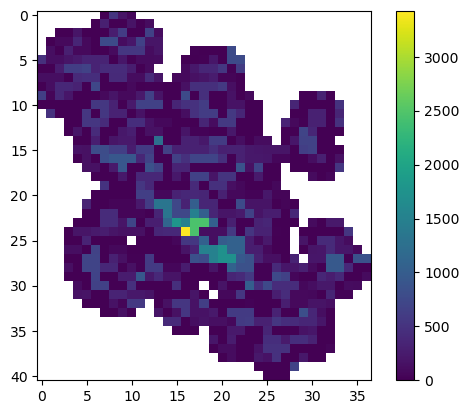

In [3]:
with rasterio.open(plume_paths[0]) as src:  # also try 3
    plume = src.read()

plt.imshow(plume[0])
plt.colorbar()

### Load point spread functions for S2, EMIT and Landsat 8

(32, 33)


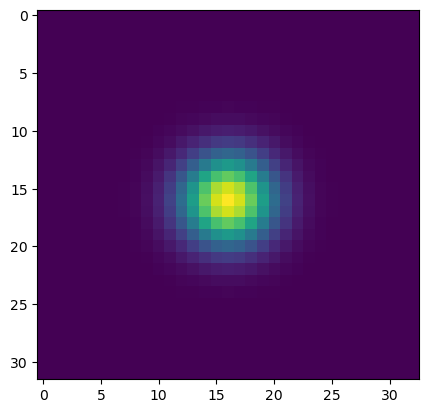

In [36]:
# S2
psf_s2 = np.loadtxt("data/point_spread_functions/S2A_PSF_B12-Table 1.txt", delimiter=",", unpack=True)
plt.imshow(psf_s2, cmap="viridis")
print(psf_s2.shape)

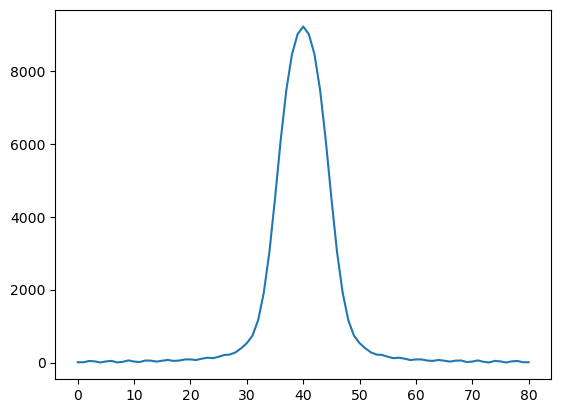

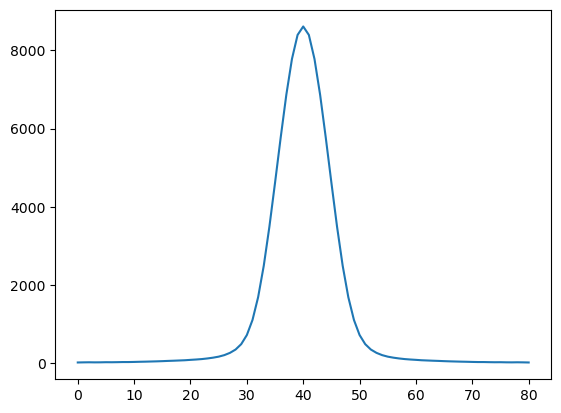

(81,)
(81,)


In [48]:
# L8
across_track_psf_l8 = np.loadtxt("data/point_spread_functions/across_track_psf_l8_b7.txt", delimiter=",", unpack=True)[
    1
]
along_track_psf_l8 = np.loadtxt("data/point_spread_functions/along_track_psf_l8_b7.txt", delimiter=",", unpack=True)[1]

plt.plot(across_track_psf_l8)
plt.show()
plt.plot(along_track_psf_l8)
plt.show()
print(across_track_psf_l8.shape)
print(along_track_psf_l8.shape)

##### Estimate EMIT SRF

In [65]:
# FOR EMIT we can just estimate the adjusted sigma from the FWHM

# Define parameters
pixel_size = 60  # EMIT resolution in meters
fwhm = 1.5 * pixel_size  # Assume PSF FWHM is ~1.5x GSD (adjust based on EMIT specs)
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # Convert FWHM to standard deviation
print(f"EMIT sigma: {sigma:.2f}")

EMIT sigma: 38.22


### Fit PSF to gaussian curve

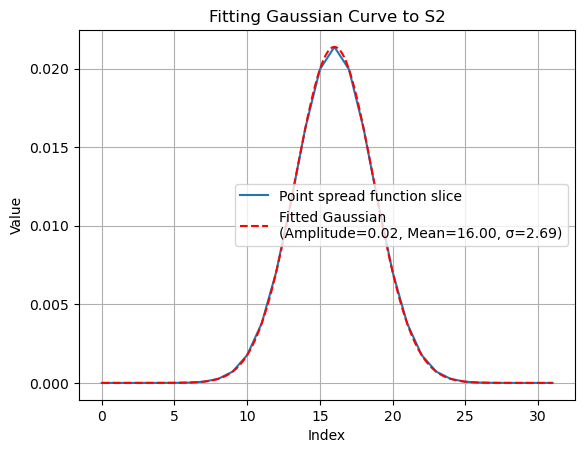

Resolution adjusted PSF sigma for S2: 10.75


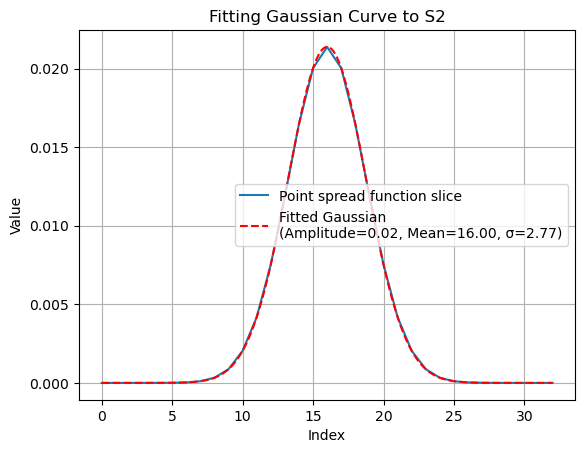

Resolution adjusted PSF sigma for S2: 11.07


In [66]:
def fit_psf_to_gaussian_2D(psf, title, window_size, spatial_resolution, direction="vertical"):
    # Generate x-values (indices) for the vertical array
    x, y = psf.shape

    if direction == "vertical":
        peak_index = int(y / 2)
        psf_1D = psf[:, peak_index]
    elif direction == "horizontal":
        peak_index = int(x / 2)
        psf_1D = psf[peak_index, :]

    x_values = np.arange(len(psf_1D))

    # Define a Gaussian function for fitting
    def gaussian(x, amplitude, mean, sigma):
        return amplitude * np.exp(-((x - mean) ** 2) / (2 * sigma**2))

    # Initial guesses for amplitude, mean, and sigma
    initial_guess = [max(psf_1D), peak_index, 1]  # Adjust mean guess to match expected peak location

    # Fit the Gaussian curve to the vertical data
    popt, _ = curve_fit(gaussian, x_values, psf_1D, p0=initial_guess)

    # Extract the fitted parameters
    amplitude, mean, sigma = popt

    # Generate the fitted Gaussian curve
    x_gaussian = np.linspace(0, len(psf_1D) - 1, 500)  # Smooth x-values
    y_gaussian = gaussian(x_gaussian, amplitude, mean, sigma)

    # Plot the vertical array and the fitted Gaussian curve
    plt.plot(x_values, psf_1D, label="Point spread function slice")
    plt.plot(
        x_gaussian,
        y_gaussian,
        label=f"Fitted Gaussian\n(Amplitude={amplitude:.2f}, Mean={mean:.2f}, σ={sigma:.2f})",
        linestyle="--",
        color="red",
    )
    plt.title(f"Fitting Gaussian Curve to {title}")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate the adjusted sigma based on the spatial resolution and window size
    # THIS IS THE ACTUAL SIGMA THAT SHOULD BE USED FOR THE PSF
    adjusted_sigma = (spatial_resolution / window_size) * sigma

    # Print the fitted parameters
    print(f"Resolution adjusted PSF sigma for {title}: {adjusted_sigma:.2f}")


fit_psf_to_gaussian_2D(psf_s2, "S2", 5, 20, "vertical")
fit_psf_to_gaussian_2D(psf_s2, "S2", 5, 20, "horizontal")

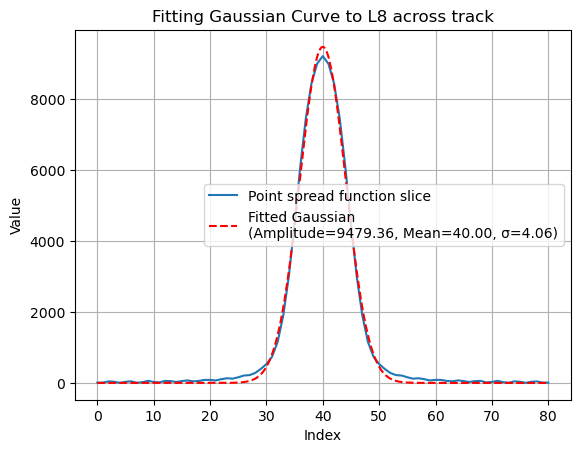

Resolution adjusted PSF sigma for L8 across track: 24.35


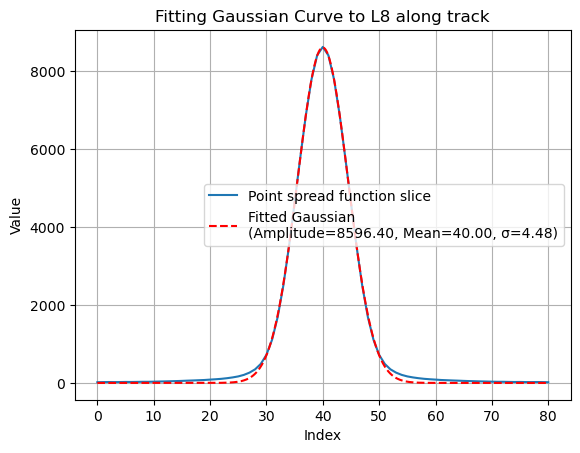

Resolution adjusted PSF sigma for L8 along track: 26.86


In [67]:
def fit_psf_to_gaussian_1D(psf_1D, title, window_size, spatial_resolution):
    # Generate x-values (indices) for the vertical array
    x = len(psf_1D)
    peak_index = int(x / 2)
    x_values = np.arange(len(psf_1D))

    # Define a Gaussian function for fitting
    def gaussian(x, amplitude, mean, sigma):
        return amplitude * np.exp(-((x - mean) ** 2) / (2 * sigma**2))

    # Initial guesses for amplitude, mean, and sigma
    initial_guess = [max(psf_1D), peak_index, 1]  # Adjust mean guess to match expected peak location

    # Fit the Gaussian curve to the vertical data
    popt, _ = curve_fit(gaussian, x_values, psf_1D, p0=initial_guess)

    # Extract the fitted parameters
    amplitude, mean, sigma = popt

    # Generate the fitted Gaussian curve
    x_gaussian = np.linspace(0, len(psf_1D) - 1, 500)  # Smooth x-values
    y_gaussian = gaussian(x_gaussian, amplitude, mean, sigma)

    # Plot the vertical array and the fitted Gaussian curve
    plt.plot(x_values, psf_1D, label="Point spread function slice")
    plt.plot(
        x_gaussian,
        y_gaussian,
        label=f"Fitted Gaussian\n(Amplitude={amplitude:.2f}, Mean={mean:.2f}, σ={sigma:.2f})",
        linestyle="--",
        color="red",
    )
    plt.title(f"Fitting Gaussian Curve to {title}")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate the adjusted sigma based on the spatial resolution and window size
    # THIS IS THE ACTUAL SIGMA THAT SHOULD BE USED FOR THE PSF
    adjusted_sigma = (spatial_resolution / window_size) * sigma

    # Print the fitted parameters
    print(f"Resolution adjusted PSF sigma for {title}: {adjusted_sigma:.2f}")


fit_psf_to_gaussian_1D(across_track_psf_l8, "L8 across track", 5, 30)
fit_psf_to_gaussian_1D(along_track_psf_l8, "L8 along track", 5, 30)

### Transformations

##### Randomly rotate and resample

In [22]:
DENSITY_AIR_GROUND_LEVEL = 1.2250  # kg/m³
M_AIR = 0.0289644  # kg/mol
UNIT_MULTIPLIER = 1e-6  # ppm


def convert_ppm_to_mol_m2(retrieval_ppm_m: np.ndarray) -> np.ndarray:
    # CALCULATIONS EXPLAINED HERE https://git.orbio.earth/orbio/wiki/-/wikis/Products/Simulator-V1/Chapter-5:-Conversions

    ppm_m_to_mol_factor = UNIT_MULTIPLIER * DENSITY_AIR_GROUND_LEVEL / M_AIR  # mol/m³/ppm

    retrieval_mol_m2 = retrieval_ppm_m * ppm_m_to_mol_factor

    return retrieval_mol_m2


def remove_whitespace_around_plume(array: np.ndarray) -> np.ndarray:
    # Find rows and columns that are not all NaN
    valid_rows = ~np.isnan(array).all(axis=1)
    valid_cols = ~np.isnan(array).all(axis=0)

    # Slice the array to the valid region
    return array[np.ix_(valid_rows, valid_cols)]


###############################################################
# NOTE: Convert sim methods to assume mol/m2 for consistency!!!
###############################################################


def load_and_transform_plume_arr(
    plume_tiff_path: str | Path,
    # blob_service_client: BlobServiceClient,
    # container_name: str,
    target_spatial_resolution: int,
    concentration_rescale_value: int,
    psf_sigma: float,
    plumes_in_ppm_m=False,
) -> npt.NDArray:
    """
    Load a plume from a tiff file in the retrieval data, and transform the plume by rotating it randomly,
    resampling it to a target resolution and reprojecting it to UTM.

    Note: Sim plumes are either stored in ppm/m
    or in mol/m2, for our sim calculations, we want the values in mol/m2 so there is an additional transformation
    if the plumes are in ppm/m.

    Parameters
    ----------
    - plume_tiff_path: Path to the input raster file.
    - target_spatial_resolution: Target pixel resolution in meters.
    - concentration_rescale_value: Rescale methane concentration values by this factor
    - reproject_to_utm: bool to reproject raster to UTM CRS
    - plumes_in_ppm_m: if plumes are in ppm_m we need to convert to mol/m2

    Return:

    Transformed plume array in mol/m2.

    """
    # local_tiff_path, temp_dir = get_local_path_for_tiff(str(plume_tiff_path), blob_service_client, container_name)
    local_tiff_path = plume_tiff_path

    with rasterio.open(local_tiff_path) as src:
        # Read the input band and replace NaN values with 0
        band = src.read(1)
        band = np.nan_to_num(band, nan=0.0)

        # rescale methane concentration values by target value
        band_adjusted = band * concentration_rescale_value

        # Get original raster dimensions
        expand_factor = math.ceil(20 / src.transform.a)
        band_adjusted = np.pad(
            band_adjusted,
            ((expand_factor, expand_factor), (expand_factor, expand_factor)),
            mode="constant",
            constant_values=0.0,
        )

        height, width = band_adjusted.shape
        max_dim = max(height, width)

        # Calculate scale factor based on target resolution
        scale_factor = target_spatial_resolution / src.transform.a  # Assuming square pixels
        scaled_dim = math.ceil(max_dim / scale_factor) * 2  # Adjust dimensions
        rotation_degrees = 0  # rng.integers(low=0, high=360)

        # Define affine transformations
        scaling_transform = Affine.scale(scale_factor)
        rotation_transform = Affine.rotation(rotation_degrees)
        translation_transform = Affine.translation(-max_dim, -max_dim)

        # Combine transforms: scaling -> rotation -> translation
        dst_transform = src.transform * rotation_transform * translation_transform * scaling_transform

        # Apply Gaussian smoothing before resampling
        sigma = psf_sigma / src.transform.a
        band_smoothed = gaussian_filter(band_adjusted, sigma=sigma)

        # Create an empty array for the output
        transformed_band = np.zeros((scaled_dim, scaled_dim), dtype=band_smoothed.dtype)

        # Reproject the raster band to the new transformation
        reproject(
            source=band_smoothed,
            destination=transformed_band,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=dst_transform,
            dst_crs=src.crs,
            resampling=Resampling.bilinear,
        )

        # Replace 0s with NaN for output processing
        transformed_band_with_nan = np.where(transformed_band == 0.0, np.nan, transformed_band)

        # Remove whitespace around the plume
        plume = remove_whitespace_around_plume(transformed_band_with_nan)

        if plumes_in_ppm_m:
            plume = convert_ppm_to_mol_m2(plume)

        return plume, src.transform.a

### Plot all 10 plumes

woop


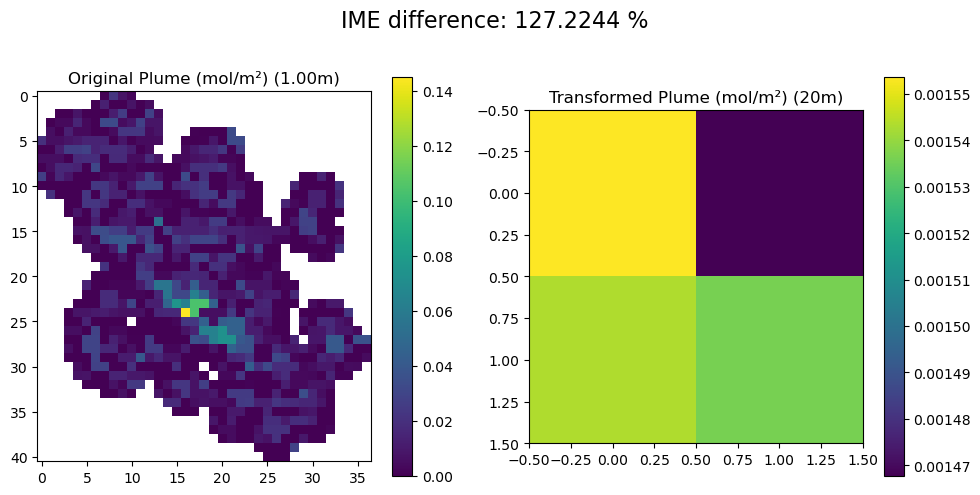

woop


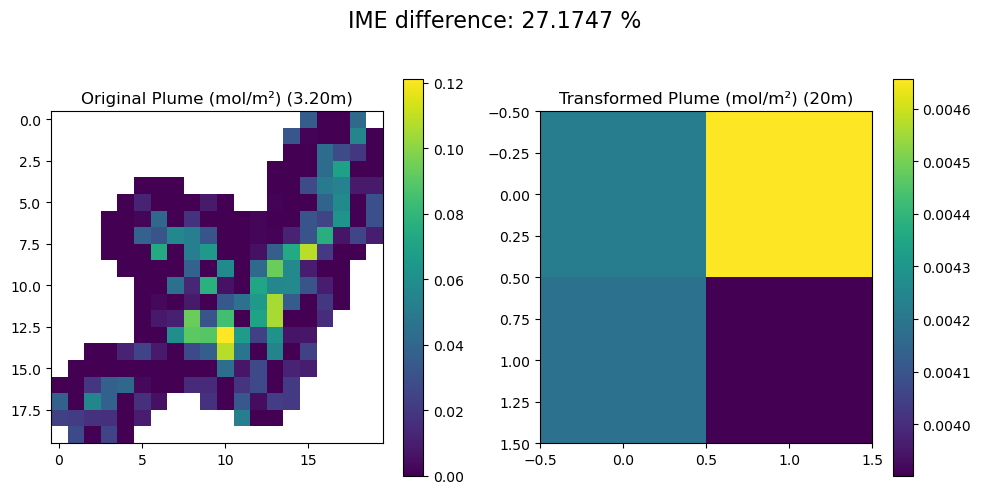

woop


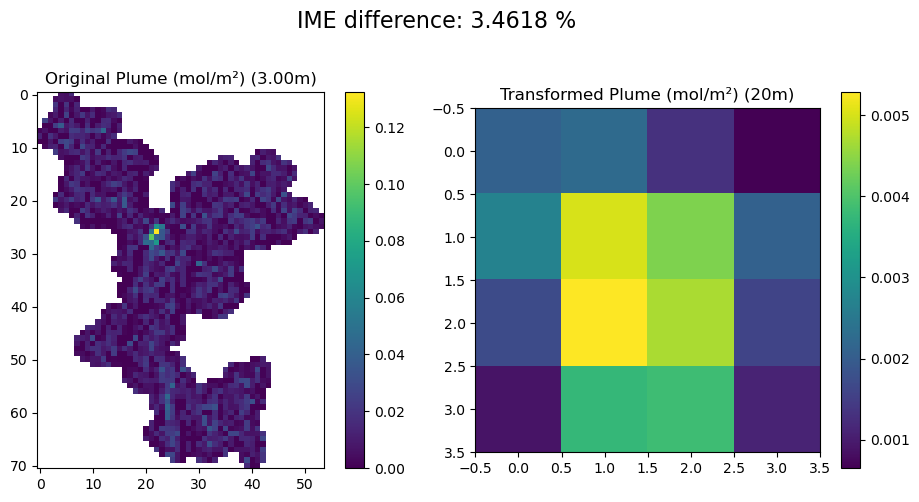

woop


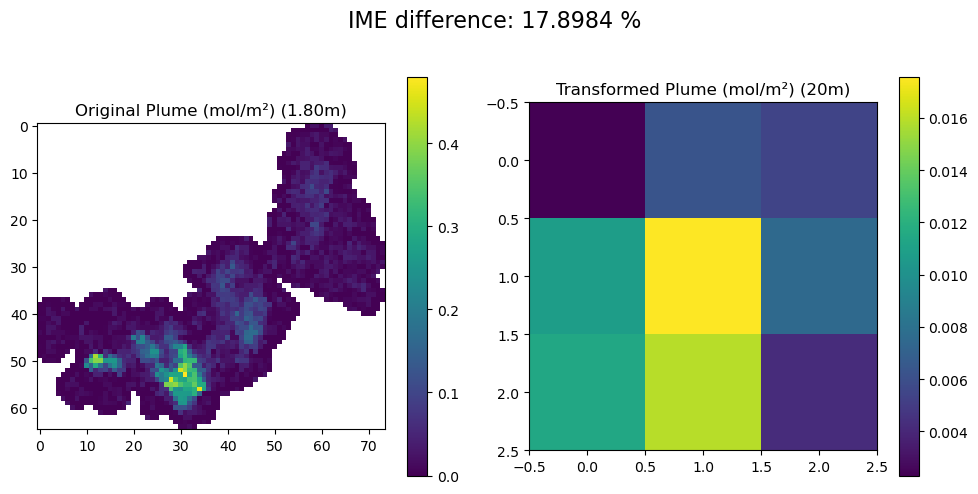

woop


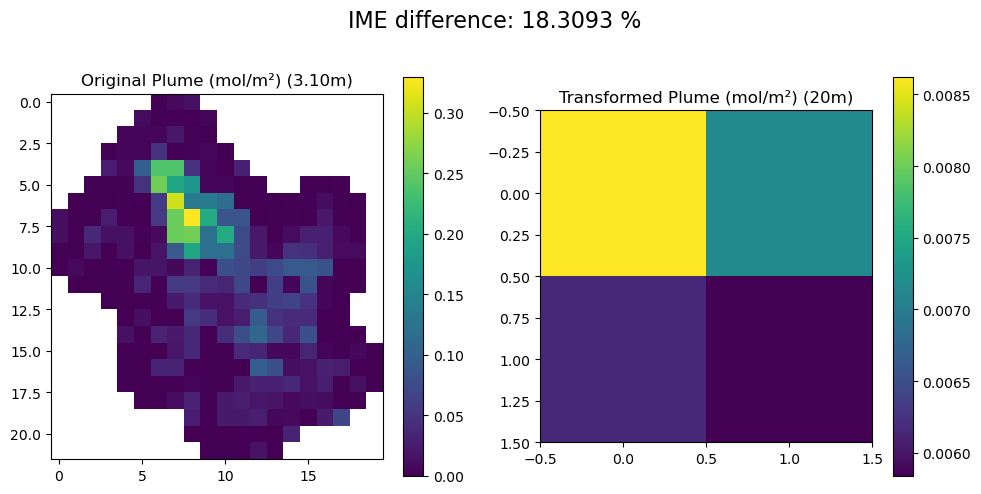

woop


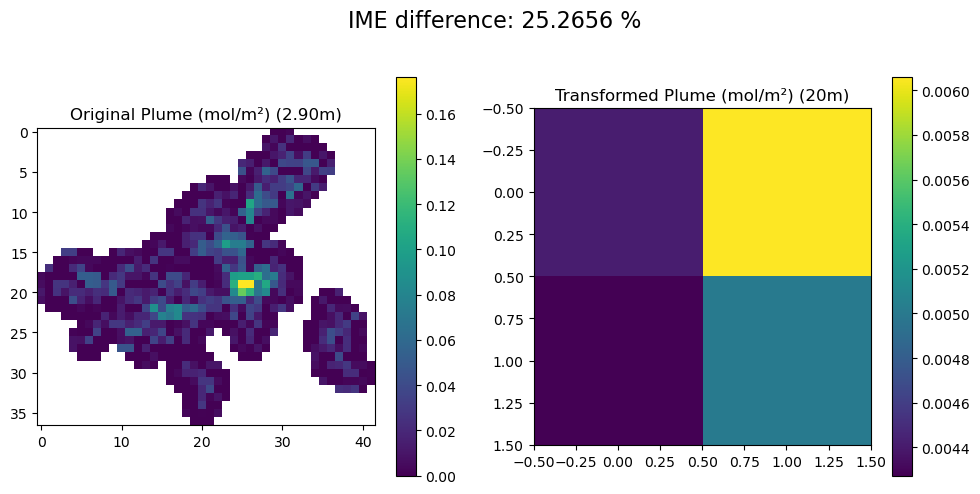

woop


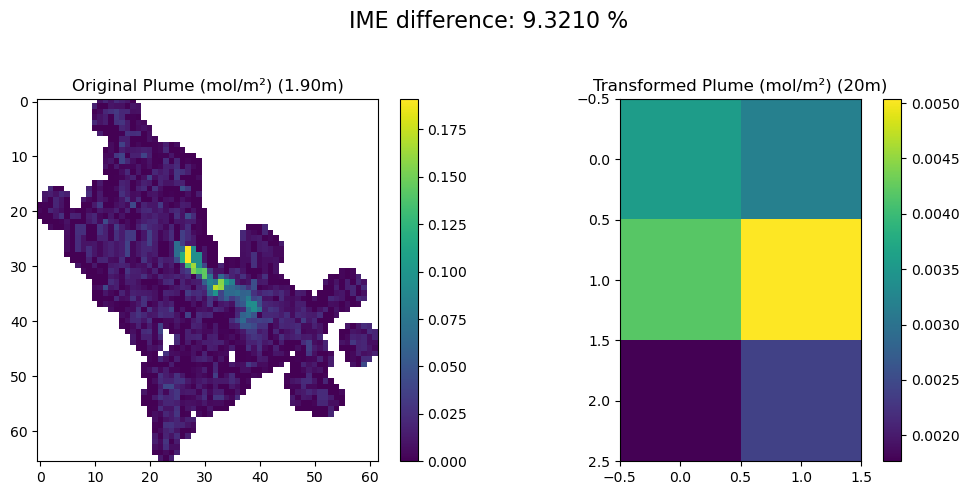

woop


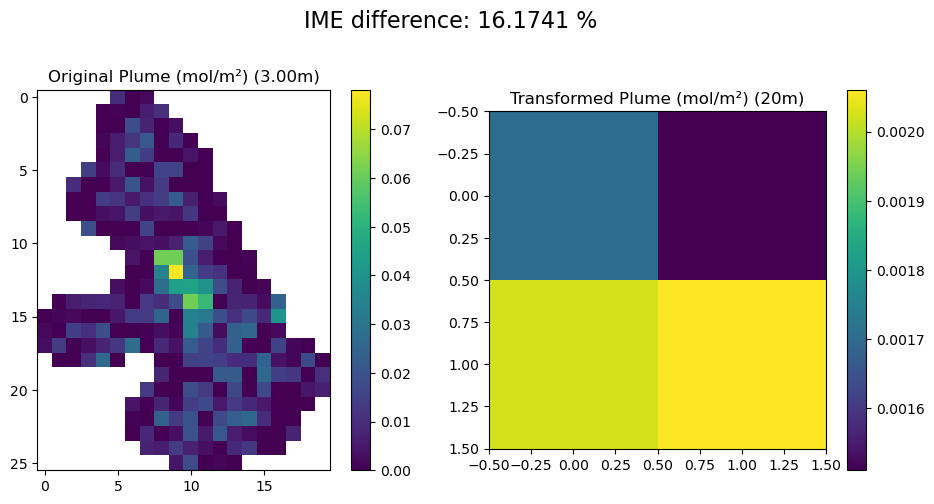

woop


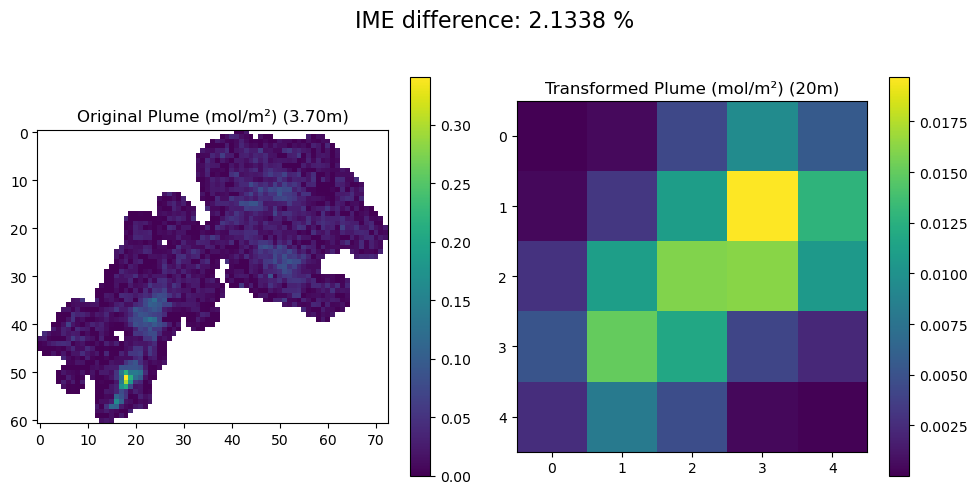

In [25]:
# Test method

# Example function to visualize the plumes
def plot_plumes(original_plume, transformed_plume, ime_diff, res):
    """Plots the original and transformed plumes side by side with the IME difference in the title."""
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot original plume
    ax = axes[0]
    im = ax.imshow(original_plume, cmap="viridis")
    ax.set_title(f"Original Plume (mol/m²) ({res:.2f}m)")
    plt.colorbar(im, ax=ax)

    # Plot transformed plume
    ax = axes[1]
    im = ax.imshow(transformed_plume, cmap="viridis")
    ax.set_title("Transformed Plume (mol/m²) (20m)")
    plt.colorbar(im, ax=ax)

    # Set the overall title with IME difference
    fig.suptitle(f"IME difference: {ime_diff:.4f} %", fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to include the suptitle
    plt.show()


def ime(plume, sensor_resolution: float = 20):
    IME = float(np.nansum(plume)) * (sensor_resolution * sensor_resolution)
    return IME


ime_loss = []
for path in plume_paths:
    print("woop")
    with rasterio.open(path) as src:
        original_plume = src.read(1)
    original_plume_mol_m2 = convert_ppm_to_mol_m2(original_plume)

    transformed_plume, org_res = load_and_transform_plume_arr(path, 60, 1, 38.22, True)
    original_ime = ime(original_plume_mol_m2, org_res)
    transformed_ime = ime(transformed_plume, 60)
    ime_loss.append(original_ime - transformed_ime)

    perc_diff = (abs(original_ime - transformed_ime) / original_ime) * 100

    plot_plumes(original_plume_mol_m2, transformed_plume, perc_diff, org_res)

In [28]:
ime_loss

[0.4806881211698055,
 0.020691346415780743,
 -2.4287928342819214,
 -22.102655796916423,
 -0.9661489761878244,
 -0.2563086139783053,
 -5.755194034544289,
 2.650447368621826,
 -50.49384067524409]